# Carlos Méndez
# Procesamiento del Lenguaje Natural

In [ ]:
# Importación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import multiprocessing
from gensim.models import Word2Vec

# Carga de la data de texto a analizar

In [ ]:
# Carga de la data
reviews = pd.read_csv('/content/sample_data/IMDB Dataset.csv')

In [ ]:
# Eliminar valores nulos (si existieran)
reviews = reviews.dropna()
print(f"\n Total de reviews en el dataframe: {len(reviews)}")


 Total de reviews en el dataframe: 50000


In [ ]:
# Eliminar valores duplicados (si existieran)
reviews = reviews.drop_duplicates()
print(f"\n Total de reviews en el dataframe: {len(reviews)}")


 Total de reviews en el dataframe: 49582


# Visualización de las primeros registros

In [ ]:
print(reviews.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# Definimos una función de limpieza para evitar crear ruido durante el análisis.

In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'<.*?>', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  tokens = text.split()
  return ' '.join(tokens)



Se la aplicamos al dataset, para eliminar etiquetas de HTML, convertir todo a minusculas, eliminar números y signos de puntuación.

In [ ]:
reviews['review'] = reviews['review'].apply(clean_text)

In [ ]:
reviews.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [ ]:
reviews['tokens'] = reviews['review'].apply(lambda x: x.split())

# Entrenamiento del modelo word2Vec

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in reviews[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

<ipython-input-12-bcbdf8a9b725>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentence_tokens.append(text_to_word_sequence(row[0]))


In [ ]:
sentence_tokens[:5]

[['one',
  'of',
  'the',
  'other',
  'reviewers',
  'has',
  'mentioned',
  'that',
  'after',
  'watching',
  'just',
  'oz',
  'episode',
  'youll',
  'be',
  'hooked',
  'they',
  'are',
  'right',
  'as',
  'this',
  'is',
  'exactly',
  'what',
  'happened',
  'with',
  'methe',
  'first',
  'thing',
  'that',
  'struck',
  'me',
  'about',
  'oz',
  'was',
  'its',
  'brutality',
  'and',
  'unflinching',
  'scenes',
  'of',
  'violence',
  'which',
  'set',
  'in',
  'right',
  'from',
  'the',
  'word',
  'go',
  'trust',
  'me',
  'this',
  'is',
  'not',
  'a',
  'show',
  'for',
  'the',
  'faint',
  'hearted',
  'or',
  'timid',
  'this',
  'show',
  'pulls',
  'no',
  'punches',
  'with',
  'regards',
  'to',
  'drugs',
  'sex',
  'or',
  'violence',
  'its',
  'is',
  'hardcore',
  'in',
  'the',
  'classic',
  'use',
  'of',
  'the',
  'wordit',
  'is',
  'called',
  'oz',
  'as',
  'that',
  'is',
  'the',
  'nickname',
  'given',
  'to',
  'the',
  'oswald',
  'maxim

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
words2vecs = Word2Vec(
    min_count=15,
    window=5,
    vector_size=100,
    negative=10,
    workers=multiprocessing.cpu_count() - 1,
    sg=1
)

A partir de allí se contruye el vocabulario.

In [ ]:
words2vecs.build_vocab(sentence_tokens)

In [ ]:
words2vecs.train(
    sentence_tokens,
    total_examples=words2vecs.corpus_count,
    epochs=15,
    report_delay=1,
    compute_loss=True,
    callbacks=[callback()])

Loss after epoch 0: 68501160.0
Loss after epoch 1: 4187248.0
Loss after epoch 2: 4676288.0
Loss after epoch 3: 4923584.0
Loss after epoch 4: 5052256.0
Loss after epoch 5: 5087688.0
Loss after epoch 6: 5080920.0
Loss after epoch 7: 5042728.0
Loss after epoch 8: 4979576.0
Loss after epoch 9: 4915192.0
Loss after epoch 10: 4835800.0
Loss after epoch 11: 4765368.0
Loss after epoch 12: 4680408.0
Loss after epoch 13: 4594976.0
Loss after epoch 14: 2894536.0


(120598882, 167626980)

# Ensayos con distintas palabras

Busqueda de similitud entre las palabras seleccionadas.

In [ ]:
# Palabras que máS se relacionan con...:
# drama
words2vecs.wv.most_similar(positive=["episode"], topn=10)

[('presented', 0.5625017285346985),
 ('dialogue', 0.5492264032363892),
 ('hallmarks', 0.5481665730476379),
 ('oneal', 0.5400444865226746),
 ('ready', 0.5260265469551086),
 ('gunn', 0.5160751342773438),
 ('morlocks', 0.5121341347694397),
 ('of', 0.5056787729263306),
 ('thrashing', 0.5043919682502747),
 ('sheen', 0.5026503205299377)]

Se evidencia que la palabra similitud con la palabra escogida son **'presented'** y **'dialogue'** lo que tiene sentido en el contexto de las reviews de un episodio de alguna serie y/o pelicula.

In [ ]:
# Palabras que máS se relacionan con...:
# offer
words2vecs.wv.most_similar(positive=["offer"], topn=10)

[('isolation', 0.568135142326355),
 ('status', 0.563427209854126),
 ('applicable', 0.5389055013656616),
 ('illustration', 0.5221008658409119),
 ('uncomfortably', 0.5165129899978638),
 ('backyard', 0.5135871171951294),
 ('auditions', 0.5058816075325012),
 ('logic', 0.5054340362548828),
 ('peters', 0.5044664740562439),
 ('biology', 0.5024338364601135)]

Las palabras con mayores similitudes (**'isolation'** y **'status'**) tienen relación con una ofrecimiento.

In [ ]:
# Palabras que máS se relacionan con...:
# movie
words2vecs.wv.most_similar(positive=["movie"], topn=10)

[('dance', 0.8222773671150208),
 ('beaches', 0.7707744836807251),
 ('face', 0.7213979363441467),
 ('politician', 0.6576536893844604),
 ('powers', 0.6462737917900085),
 ('writerdirector', 0.6385561227798462),
 ('dream', 0.6261223554611206),
 ('lows', 0.5691156387329102),
 ('fallacy', 0.5609317421913147),
 ('conservatory', 0.5454485416412354)]

Para este caso, esta mostrando mayor similitud con términos como **dance**, **beaches** y **face**. Muestra correspondencia con tipos de peliculas con baile, escenificadas en playas o que la trama implique enfrentar (**face**) situaciones difíciles.

In [ ]:
# Palabras que máS se relacionan con...:
# story
words2vecs.wv.most_similar(positive=["story"], topn=10)

[('emphasize', 0.7151013016700745),
 ('saxophone', 0.6284725069999695),
 ('convoluted', 0.6249318718910217),
 ('paulo', 0.601096510887146),
 ('should', 0.5988489389419556),
 ('ant', 0.566592276096344),
 ('cv', 0.5549416542053223),
 ('act', 0.5522491931915283),
 ('seem', 0.5447239279747009),
 ('endeavor', 0.5446268320083618)]

Para este caso, esta mostrando mayor similitud con términos como **emphasize**, **saxophone** y **convoluted**. Muestra correspondencia con tipos de peliculas con tramas e historias donde se **enfatizan** historias **complejas**.

In [ ]:
# Palabras que máS se relacionan con...:
# good
words2vecs.wv.most_similar(positive=["good"], topn=10)

[('bucket', 0.699196994304657),
 ('sat', 0.66582852602005),
 ('title', 0.655507504940033),
 ('see', 0.6548861265182495),
 ('cold', 0.6541019082069397),
 ('stalwart', 0.646281898021698),
 ('dr', 0.6410956382751465),
 ('funnily', 0.6245826482772827),
 ('soontobe', 0.6218600869178772),
 ('motherhood', 0.6119585633277893)]

El término **good** tiene mayor relación con los términos **bucket**, **'sat'** y **title**, con la lógica asociación de títulos, o triste(za) para films.

En términos generales el modelo esta reflejando bastante bien las relaciones, en el contexto planteado.

# Visualización

In [ ]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 3 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(words2vecs)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])

fig.show(renderer="colab")

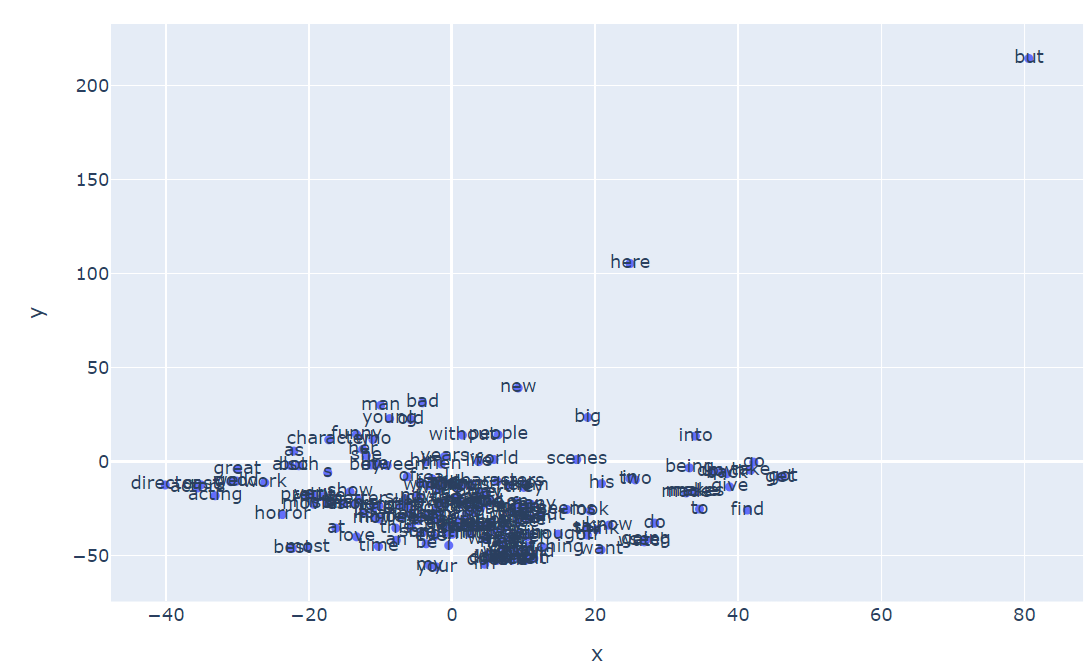

Existe un acumulamiento de puntos en ciertas zonas, por lo que haremos algunos ajustes de limites para validar mejor el sentido de las relaciones entre palabras.

In [ ]:
MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.update_xaxes(range=[0, 15])
fig.update_yaxes(range=[-60, 0])
fig.show(renderer="colab") # esto para plotly en colab

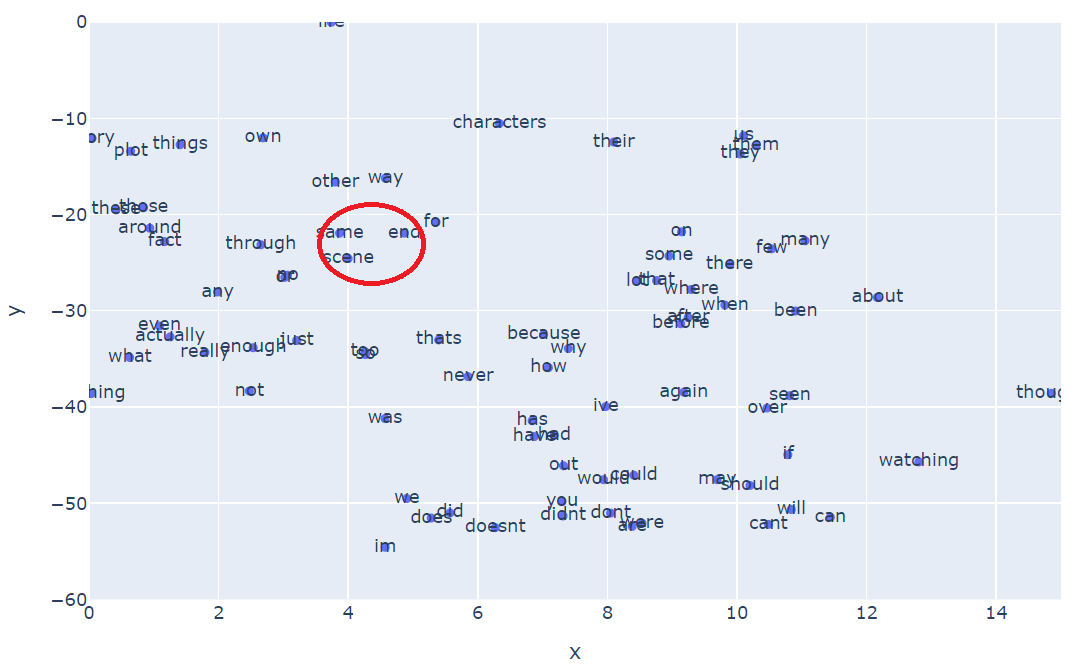

La cercania de los puntos muestra mayor similitud entre sí. Por ejemplo, las palabras **end**, **same** y **scene** suelen estar muy relacionadas en el contexto (para aquellos comentarios donde se refieren a escenas de peliculas). Una posible ocurrencia de términos conjuntos como **"same ecene"** o **"end scene"** puede explicar la similitud y cercanía en el gráfico.